In [1]:
!git clone https://github.com/harshpx/VarCnn/

Cloning into 'VarCnn'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Receiving objects: 100% (55/55), 89.34 MiB | 933.00 KiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
%%capture
!unzip /kaggle/working/VarCnn/data/var600.zip

In [3]:
!cd /kaggle/working
!mv VAR data

In [93]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPool2D,Dense,Dropout,GlobalAveragePooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model

In [80]:
data_path = "/kaggle/working/data"
output_path = "/kaggle/working"
input_shape = (256,256)

In [81]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,brightness_range=[1.2,2],
                           horizontal_flip=True,vertical_flip=True,rotation_range=90)
train_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='training',target_size=input_shape)
val_data=datagen.flow_from_directory(data_path,batch_size=32,class_mode='binary',subset='validation',target_size=input_shape)

Found 964 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [82]:
print(train_data.class_indices)
print(val_data.class_indices)

{'Clean_Tackles': 0, 'Fouls': 1}
{'Clean_Tackles': 0, 'Fouls': 1}


In [83]:
# base_model = EfficientNetB4(input_shape=(224,224,3),weights='imagenet',include_top=False)

In [84]:
# base_model.trainable = False

# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1,activation='sigmoid'))

In [85]:
# Creating model from scratch:
inputs=Input(shape=(256,256,3))
#Initial Layers of 256 Filters 
x = Conv2D(64,5,padding='same')(inputs)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(inputs)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(64,5,padding='same')(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Decreasing Filters and MAxPool Layers
x = Conv2D(32,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPool2D(strides=(2,2))(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
# x = BatchNormalization()(x)
x = Conv2D(16,3,padding='same',dilation_rate=2)(x)
x = Activation(activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)

 #Dense Layers
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(400)(x)
x = Dropout(0.5)(x)
x = Activation(activation='relu')(x)
x = Dense(1)(x)

#Output
out = Activation(activation='sigmoid')(x)

# final model:
model = Model(inputs,out,name='BaseModel')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [86]:
model.load_weights('/kaggle/working/VarCnn/varCNN/inferences/pretraineModel/weights.h5')

In [87]:
# training model:
es=EarlyStopping(monitor='val_accuracy',patience=7,verbose=0,restore_best_weights=True)
logs=model.fit(train_data,validation_data=val_data,epochs=100,callbacks=[es])

Epoch 1/100
31/31 [==============================] - 26s 717ms/step - loss: 0.7312 - accuracy: 0.5166 - val_loss: 0.6894 - val_accuracy: 0.5458
Epoch 2/100
31/31 [==============================] - 21s 673ms/step - loss: 0.6656 - accuracy: 0.5809 - val_loss: 0.6668 - val_accuracy: 0.5917
Epoch 3/100
31/31 [==============================] - 22s 700ms/step - loss: 0.6405 - accuracy: 0.6380 - val_loss: 0.7062 - val_accuracy: 0.5292
Epoch 4/100
31/31 [==============================] - 21s 681ms/step - loss: 0.6315 - accuracy: 0.6535 - val_loss: 0.6990 - val_accuracy: 0.6250
Epoch 5/100
31/31 [==============================] - 22s 713ms/step - loss: 0.6423 - accuracy: 0.6598 - val_loss: 0.6069 - val_accuracy: 0.6625
Epoch 6/100
31/31 [==============================] - 21s 676ms/step - loss: 0.6183 - accuracy: 0.6608 - val_loss: 0.5791 - val_accuracy: 0.6542
Epoch 7/100
31/31 [==============================] - 22s 702ms/step - loss: 0.6285 - accuracy: 0.6276 - val_loss: 0.6159 - val_accuracy:

In [88]:
clear_session()

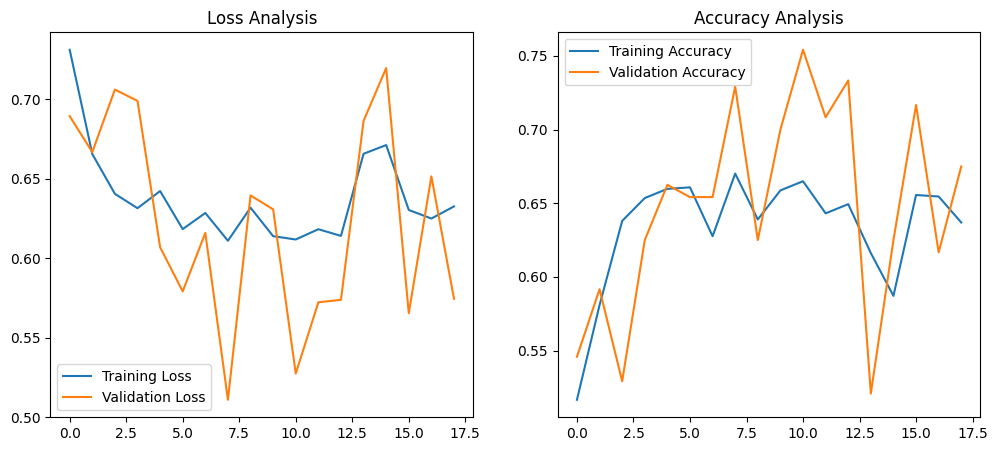

In [120]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(logs.history['loss'], label='Training Loss')
plt.plot(logs.history['val_loss'], label='Validation Loss')
plt.title('Loss Analysis')
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs.history['accuracy'], label='Training Accuracy')
plt.plot(logs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Analysis')
plt.legend()
plt.show()

In [91]:
model.evaluate(val_data)

8/8 [==============================] - 4s 508ms/step - loss: 0.5301 - accuracy: 0.7375


[0.5300807952880859, 0.737500011920929]

In [121]:
model.save('/kaggle/working/best_model.h5')

## Final validation accuracy: ~74%